Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Serena Liang"
COLLABORATORS = "Tianyu Bao, Usama Rathore"

---

In [2]:
def test():
    pass

# Create as many cells as you need BELOW this cell

# Import Libraries

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn import svm

from sklearn import preprocessing
import sqlite3

# Load the dataset

### Load Raw data

In [4]:
raw_data = pd.read_csv('train.csv')

- we need to load the data first into order to use it, however we did the sql portion of creating the table and inserting the data

### Import data using SQL

In [5]:
def create_connection(db_file, delete_db=False):
    
    '''Establish connection'''
    
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    return conn

In [6]:
def create_table(conn, create_table_sql, drop_table_name=None):
    
    '''Create SQL tables'''
    
    if drop_table_name:
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

#### Create SQL statement for the dataset

In [7]:
create_table_sql = "create table [PriceData] ( "
column_template = "[{col_name}] {col_type} , "

insert_sql_names = "insert into PriceData(";
insert_sql_values = "values("

for ind, val in raw_data.dtypes.items(): 
    if val == int:
        create_table_sql += column_template.format(col_name = ind, col_type = "integer")
    elif val == float:
        create_table_sql += column_template.format(col_name = ind, col_type = "real")
    elif val == object:
        create_table_sql += column_template.format(col_name = ind, col_type = "text")

    insert_sql_names += "'" + ind + "',"
    insert_sql_values += "?,"

create_table_sql += "primary key (Id));"
insert_sql = insert_sql_names[:-1] + ") " + insert_sql_values[:-1] + ");"

print(create_table_sql)
print(insert_sql)

create table [PriceData] ( [Id] integer , [MSSubClass] integer , [MSZoning] text , [LotFrontage] real , [LotArea] integer , [Street] text , [Alley] text , [LotShape] text , [LandContour] text , [Utilities] text , [LotConfig] text , [LandSlope] text , [Neighborhood] text , [Condition1] text , [Condition2] text , [BldgType] text , [HouseStyle] text , [OverallQual] integer , [OverallCond] integer , [YearBuilt] integer , [YearRemodAdd] integer , [RoofStyle] text , [RoofMatl] text , [Exterior1st] text , [Exterior2nd] text , [MasVnrType] text , [MasVnrArea] real , [ExterQual] text , [ExterCond] text , [Foundation] text , [BsmtQual] text , [BsmtCond] text , [BsmtExposure] text , [BsmtFinType1] text , [BsmtFinSF1] integer , [BsmtFinType2] text , [BsmtFinSF2] integer , [BsmtUnfSF] integer , [TotalBsmtSF] integer , [Heating] text , [HeatingQC] text , [CentralAir] text , [Electrical] text , [1stFlrSF] integer , [2ndFlrSF] integer , [LowQualFinSF] integer , [GrLivArea] integer , [BsmtFullBath] int

#### Execute SQL statements
- create our table
- data insertion

In [8]:
db_dir = os.path.join('/content/gdrive/My Drive/EAS503Project/house_price.db')
conn = create_connection('house_price.db')


with conn:
    create_table(conn, create_table_sql, 'PriceData')
    cur = conn.cursor()
    cur.executemany(insert_sql, raw_data.values.tolist())

#### Fetch data from the database 

In [9]:
cur = conn.cursor()
df = pd.read_sql_query("""select * from PriceData""", conn)

In [10]:
df.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500


# Data Structure Exploration

#### Check the size of the dataset

In [11]:
df.shape

(1460, 81)

#### Check all the features 

In [12]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

#### Check feature datatypes

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

 - dataset consists of 37 numerical variables, and 43 cateogrical variables, not including the response variable which is also continuous

# Data Visualization

### Visualizing the response variable

In [14]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:>

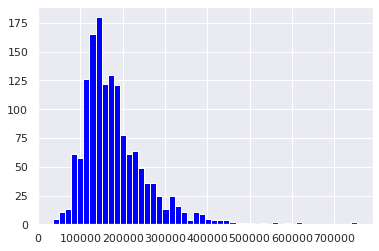

In [15]:
df['SalePrice'].hist(bins=50,color="blue")

- - "SalePrice" has slight positive skewness, with majority of sale price being close to 200,000. As shown above, the mean of "SalePrice" is ~$180000


In [16]:
print("Skewedness: %f" %df['SalePrice'].skew())
print("Kurtosis: %f" %df['SalePrice'].kurt())

Skewedness: 1.882876
Kurtosis: 6.536282


- - an acceptable range for skewedness and kurtosis [-2,2] and [-7,7] respectively in order to establish normality assumption. "SalePrice" falls within this range. We can treat this variable as normality distributed

### Correlation

#### Find variables that are highly correlated with the response variable, and visualize the distribution with respect to "SalePrice"

In [17]:
correlation = df.corr()['SalePrice']
correlation.sort_values(ascending=False).head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

In [18]:
correlation.sort_values(ascending=False).tail(10)

BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

Looking at top correlated variables, with correlation greater than |0.60|
- as shown above these variables are:
  - "OverallQual"
  - "GrLivArea"
  - "GarageCars"
  - "GarageArea"
  - "TotalBsmtSF"
  - "1stFlrSF"
  

#### Pairwise plot among these features 

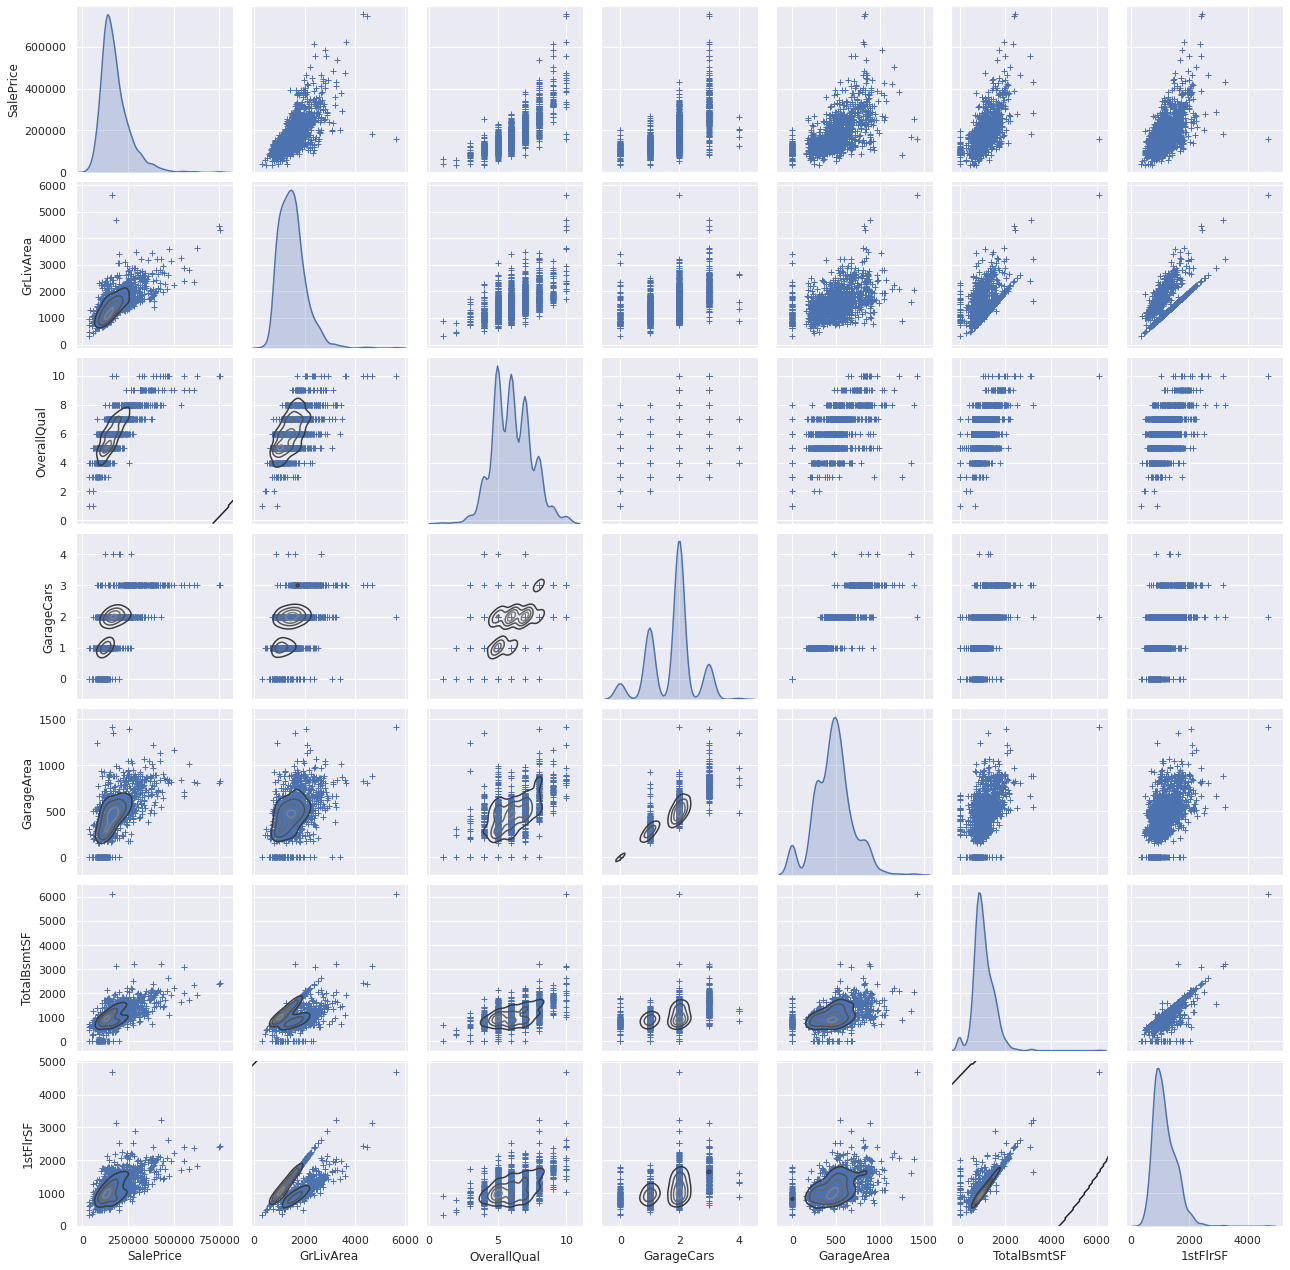

In [19]:
cols = ['SalePrice','GrLivArea', 'OverallQual', 'GarageCars', 'GarageArea','TotalBsmtSF','1stFlrSF']
pair_plot= sns.pairplot(df[cols], diag_kind="kde",plot_kws=dict(marker="+", linewidth=1),palette="red")
pair_plot.map_lower(sns.kdeplot, levels=4, color=".6")


- Visually, we can see that there are some correlation between 
  - "OverallQual" and "GrLivArea"
  - "OverallQual" and "GarageArea"
  - "OverallQual" and "TotalBsmtFlr"
  - "OverallQual" and "1stFlrSR"
  - "GarageArea" and "GarageCars"
  - "GrLivArea" and "1stFlrSR"
  - "GrLivArea" and "TotalBsmtFlr"
  - "TotalBsmtFlr" and "1stFlrSR"


#### Plot a correlation heatmap

<AxesSubplot:>

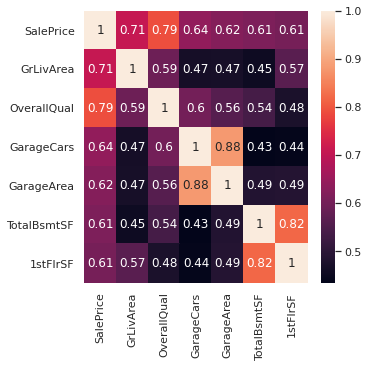

In [20]:
correlation = df[cols].corr()
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(correlation,annot=True)

- By looking at the correlation heatmap, there is significant correlation between:
  - "GarageCars" and "GarageArea"
  - "1stFlrSF" and "TotalBsmtSF"

#### correlation graph of all variables before any feature selection and cleaning

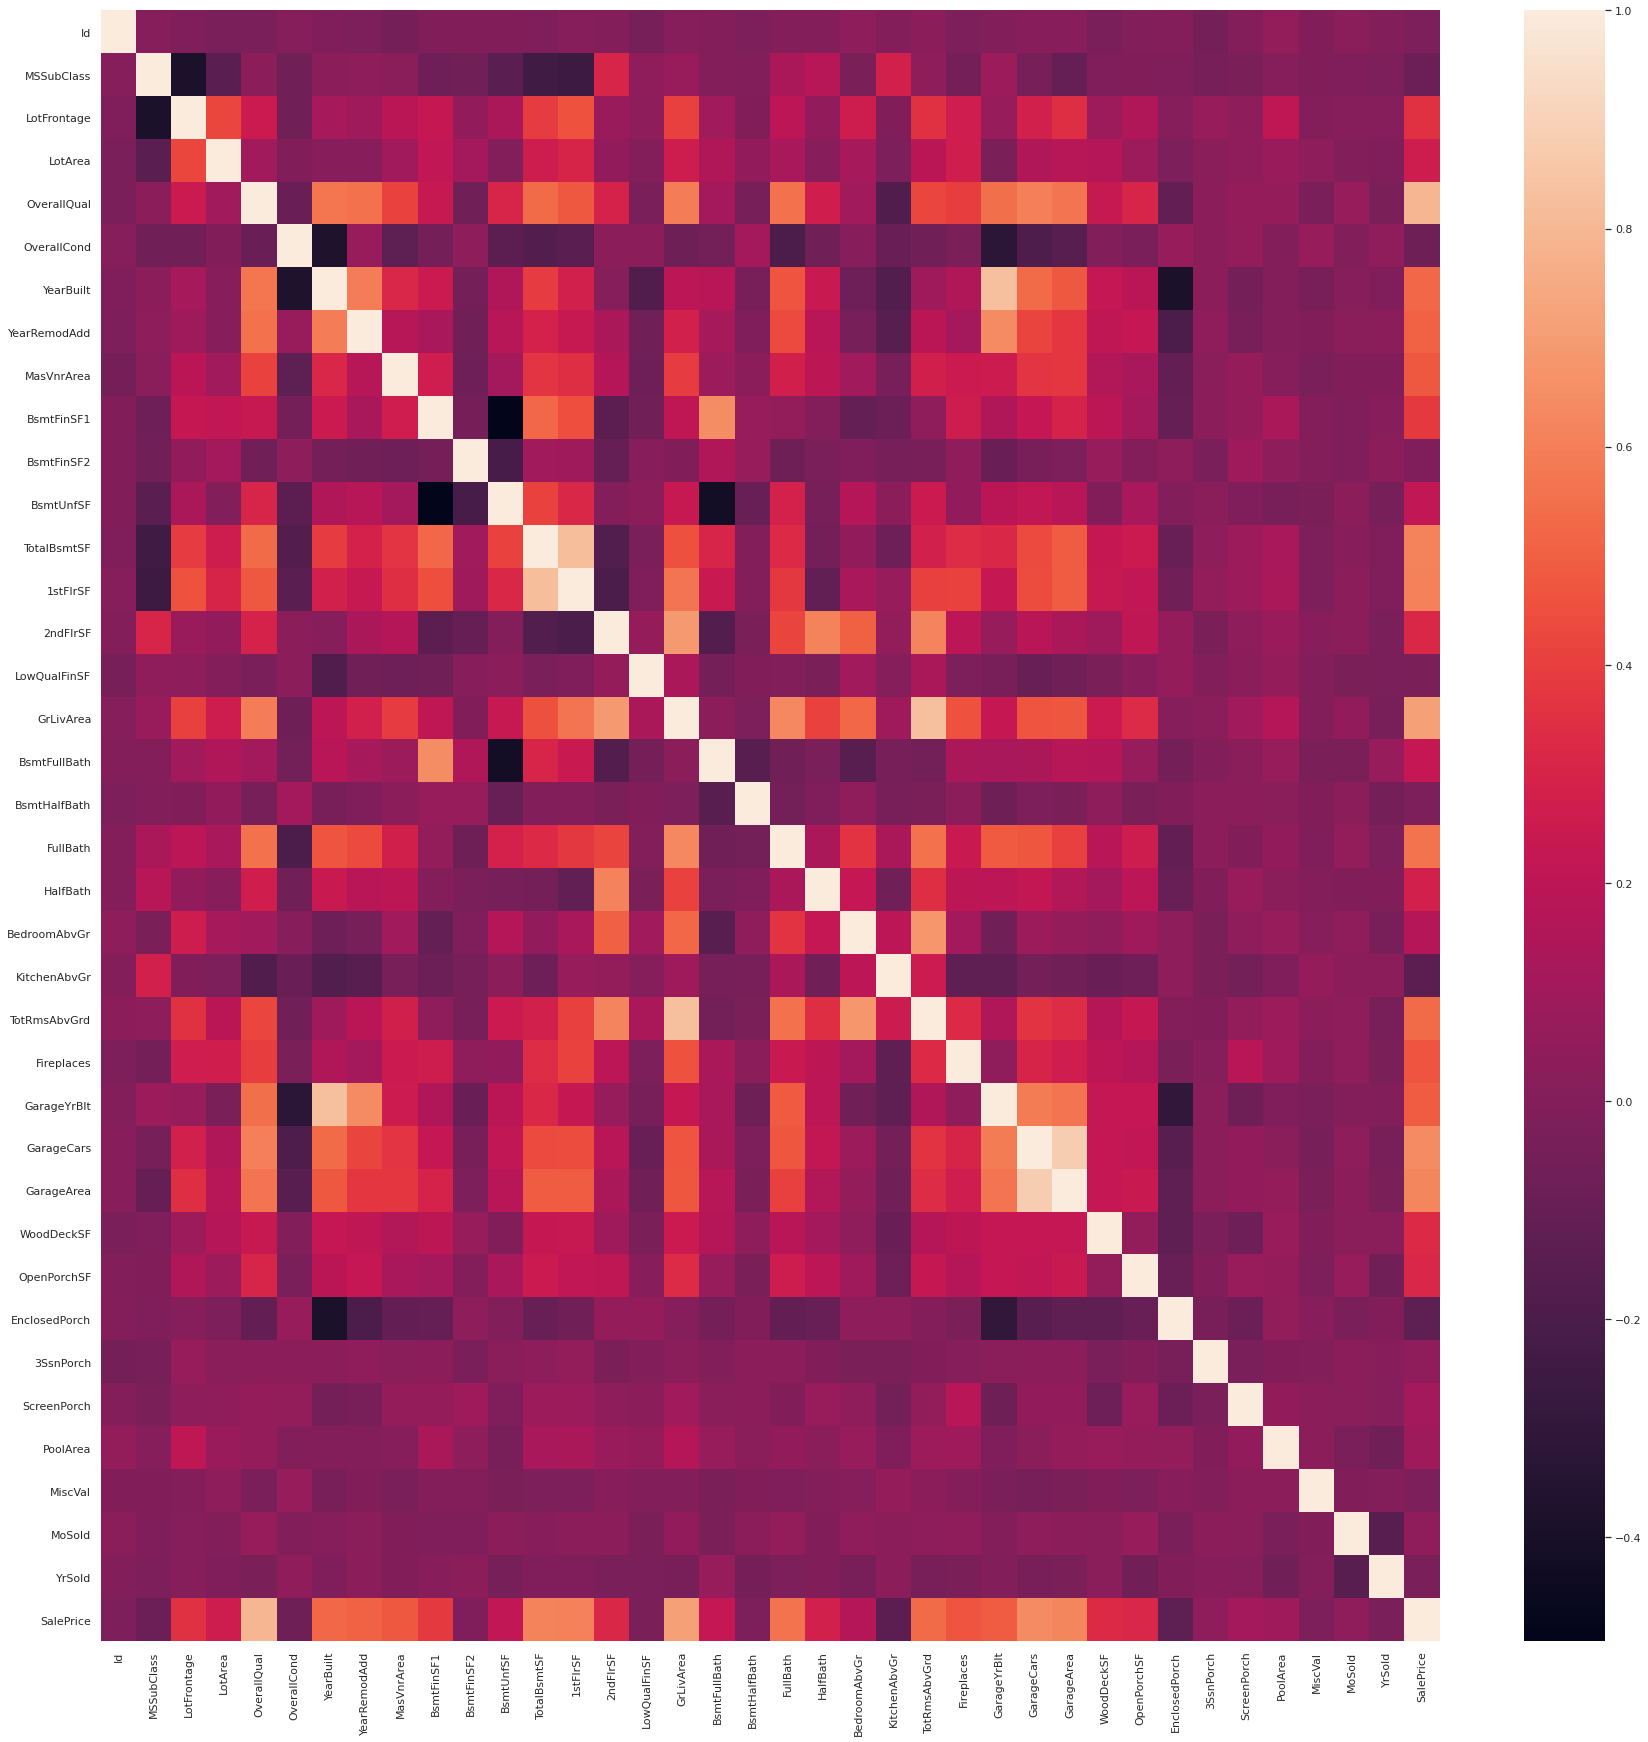

In [21]:
correlation = df.corr()
f, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(correlation);

- It is difficult to examine the entire heatmap since there are 80 varaibles, but what we can gather is that there aren't many variables that has high correlation values with "SalePrice". We can also see some multicollinearity between other dependent variables.


#### Barchart - a better visualization of correlation between features and "SalePrice"

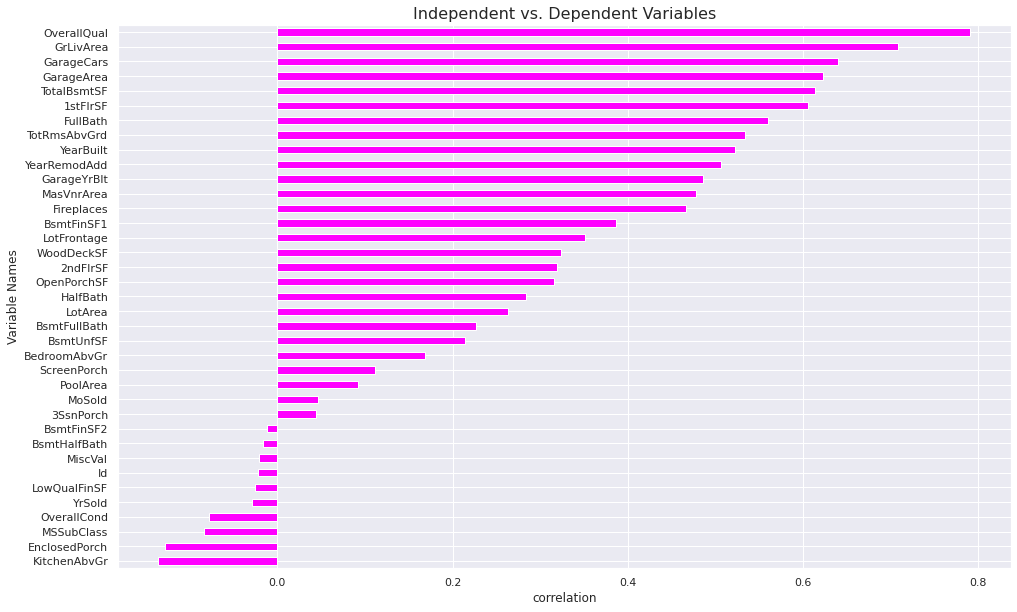

In [22]:
ax = df.corr()['SalePrice'].sort_values()[:-1].plot(kind='barh', figsize=(16,10),color="magenta")
ax.set_title('Independent vs. Dependent Variables', fontsize=16)
ax.set_xlabel('correlation')
ax.set_ylabel('Variable Names');

# Data Cleaning

#### Find total missing variables

In [23]:
total_missing = df.isnull().sum().sort_values(ascending=False)
missing_data = pd.DataFrame(total_missing)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent], axis=1, keys=['total_missing', 'Percent'])
missing_data.head(20)


,total_missing,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


#### Barchart of the missing data

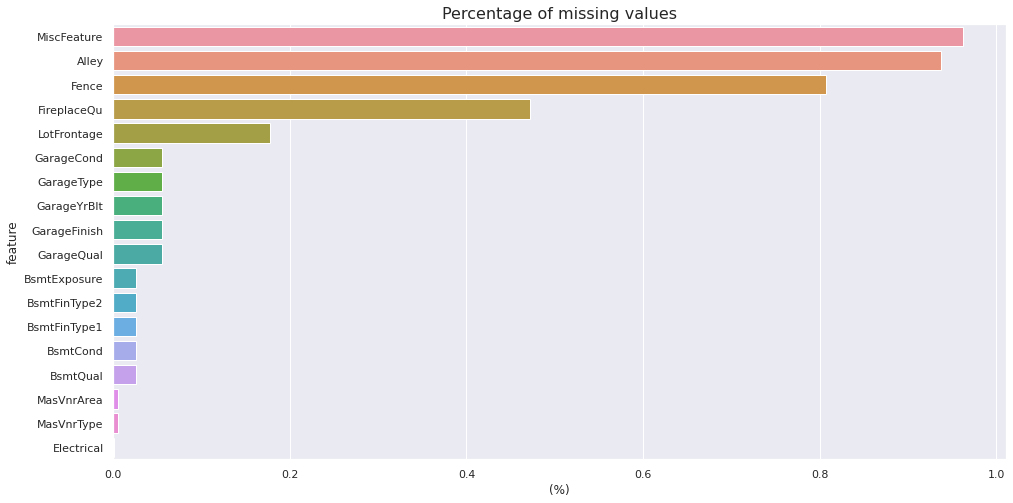

In [24]:
missing_data = missing_data.iloc[1:19,]
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.barplot(missing_data['Percent'],missing_data.index)
ax.set_xlabel('(%)')
ax.set_ylabel('feature')
ax.set_title('Percentage of missing values', fontsize=16);

- We should remove variables with greater than 15% of values missing, hence we will remove:
  - PoolQC
  - MiscFeature
  - Alley
  - Fence
  - FireplaceQu
  - LotFrontage	

#### Dropping the columns

In [25]:
df.drop(["PoolQC","MiscFeature","Alley","Fence","FireplaceQu","LotFrontage"],inplace=True,axis=1)
df.shape

(1460, 75)

#### Check the correlation between the rest of the missing values and the response variable

- We can make an observation from number of datapoints missing:
  - The variables starting with "Garage%", all have 81 missing variables
  - The variables starting with "BSMT%", all have 37-38 missing variables
  - The variables starting with "MasVnr%", all have 8 missing variables
  - "Eletrical" variable is misisng one datapoint, this can be random 
- we can conclude that the missing values is not random, we can also estimate that they came from the same observations respectively


In [26]:
## Need to make all the datatype numeric before doing this
categorical_data = df.select_dtypes(include=['object'])
for var in categorical_data.columns:
    df[var] = pd.factorize(df[var])[0]


In [27]:
missing_data = df[['SalePrice','GarageCond','GarageType','GarageYrBlt','GarageFinish','GarageQual','BsmtFinType1','BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','MasVnrArea','Electrical','MasVnrType']]

In [28]:
correlation = missing_data.corr()
correlation['SalePrice']

SalePrice       1.000000
GarageCond      0.041361
GarageType     -0.031803
GarageYrBlt     0.486362
GarageFinish    0.247470
GarageQual      0.083479
BsmtFinType1   -0.299343
BsmtExposure    0.244946
BsmtCond       -0.021549
BsmtQual        0.058965
BsmtFinType2   -0.023492
MasVnrArea      0.477493
Electrical     -0.230830
MasVnrType     -0.022405
Name: SalePrice, dtype: float64

- Variables with largest correlation with "SalePrice" are "GarageYrBlt" and "MasVnrArea" with correlation all arond ~.48
- we can same that all Garage% variables should be similar to each other, since we already have GarageCars and GarageArea having greater than ~.64 correlation to "SalePrice", keeping those two is representative of keeping all Garage% variables
- we can same that all Bsmt% variables should be similar to each other. We already have "TotalBsmtSF" with ~0.61 correlation to "SalePrice". We can then drop all Bsmt% variables with missing data. 
- We can drop "MasVnrType", since we already "MasVnrArea" is more correlated with "SalePrice"

In [29]:
missing_data.columns

Index(['SalePrice', 'GarageCond', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageQual', 'BsmtFinType1', 'BsmtExposure', 'BsmtCond', 'BsmtQual',
       'BsmtFinType2', 'MasVnrArea', 'Electrical', 'MasVnrType'],
      dtype='object')

#### Dropping uncorrelated columns

In [30]:
cols = ['GarageCond', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageQual', 'BsmtFinType1', 'BsmtExposure', 'BsmtCond', 'BsmtQual',
       'BsmtFinType2', 'MasVnrType']

In [31]:
df.drop(cols,axis=1,inplace=True)
df.shape

(1460, 64)

- We sill have "MasVnrArea" and "Electrical" with missing values, we can impute "MasVnrArea" with mean (numerical variable), and "Electrical" with max counts (factor) using fillna

#### Impute the remaining missing values

In [32]:
df = df.fillna({'MasVnrArea': df['MasVnrArea'].mean()})
df['Electrical'].fillna(df['Electrical'].value_counts().index[0],inplace=True)
sum(df.isnull().any())

0

no missing values

# Train test split

#### Separate the dependent and independent variables from the cleaned training set

In [33]:
X = df[df.columns[0:63]] 
y = df['SalePrice']

#### Split the data 
- 2/3 in training set
- 1/3 in testing set

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### Merge X and y together for simplicity in analysis

In [35]:
train_df = pd.concat([X_train,y_train],axis=1)
test_df = pd.concat([X_test,y_test],axis=1)

# Feature Selection - Random Forest technique
- we need to perform feature selection on the training set only, as this could introduce bias to our testing set

#### Fit random forest

In [36]:
rf = RandomForestRegressor(n_estimators = 500)
rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=500)

#### Use SelectFromModel() function, we can select the important features resulted from the random forest model

In [37]:
sel = SelectFromModel(RandomForestRegressor(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor())

In [38]:
selected_feat= X_train.columns[(sel.get_support())]
print(f"number of important features: {len(selected_feat)}")
print(selected_feat)

number of important features: 9
Index(['LotArea', 'OverallQual', 'YearBuilt', 'BsmtFinSF1', 'TotalBsmtSF',
       '1stFlrSF', 'GrLivArea', 'GarageCars', 'GarageArea'],
      dtype='object')


#### Check feature importance
- barplot for the entire feature space and the selected 9

<AxesSubplot:>

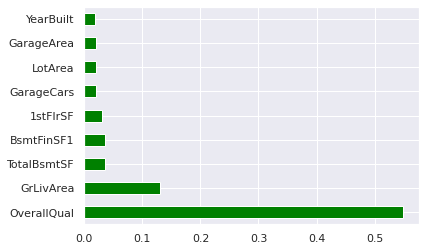

In [39]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(9).plot(kind='barh',color="green")

In [40]:
feat_importances.nlargest(9)

OverallQual    0.549297
GrLivArea      0.130685
TotalBsmtSF    0.036217
BsmtFinSF1     0.035321
1stFlrSF       0.030024
GarageCars     0.020912
LotArea        0.019401
GarageArea     0.019300
YearBuilt      0.017807
dtype: float64

We can see from the bar chart and the correlation heatmap that:
  - "OverallQual" is the most important variable, also most correleted variables with "SalePrice"

#### Redefine the dataset with the selected features - done on the entire dataset

In [41]:
df = df[['SalePrice','LotArea', 'OverallQual', 'YearBuilt', 'BsmtFinSF1', 'TotalBsmtSF',
                      '1stFlrSF', 'GrLivArea', 'GarageCars', 'GarageArea']]
df.shape

(1460, 10)

#### Correlation betweent the 9 selected features and the repsonse variable

<AxesSubplot:>

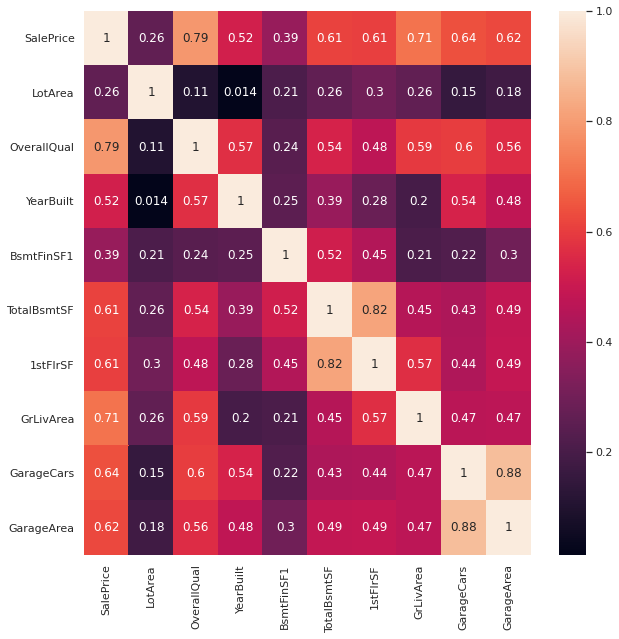

In [42]:
correlation = df.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(correlation,annot=True)

# Feature Transformation
- Feature transformation can be performed to reduce the skewness of the variables
- We can perform feature transformation on the overall data, since transformation will not introduce bias for the testing set, we will split the test same way as before afterward.

#### Visualize the distribution of the features

array([[<AxesSubplot:title={'center':'SalePrice'}>,
        <AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'OverallQual'}>],
       [<AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'BsmtFinSF1'}>,
        <AxesSubplot:title={'center':'TotalBsmtSF'}>],
       [<AxesSubplot:title={'center':'1stFlrSF'}>,
        <AxesSubplot:title={'center':'GrLivArea'}>,
        <AxesSubplot:title={'center':'GarageCars'}>],
       [<AxesSubplot:title={'center':'GarageArea'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

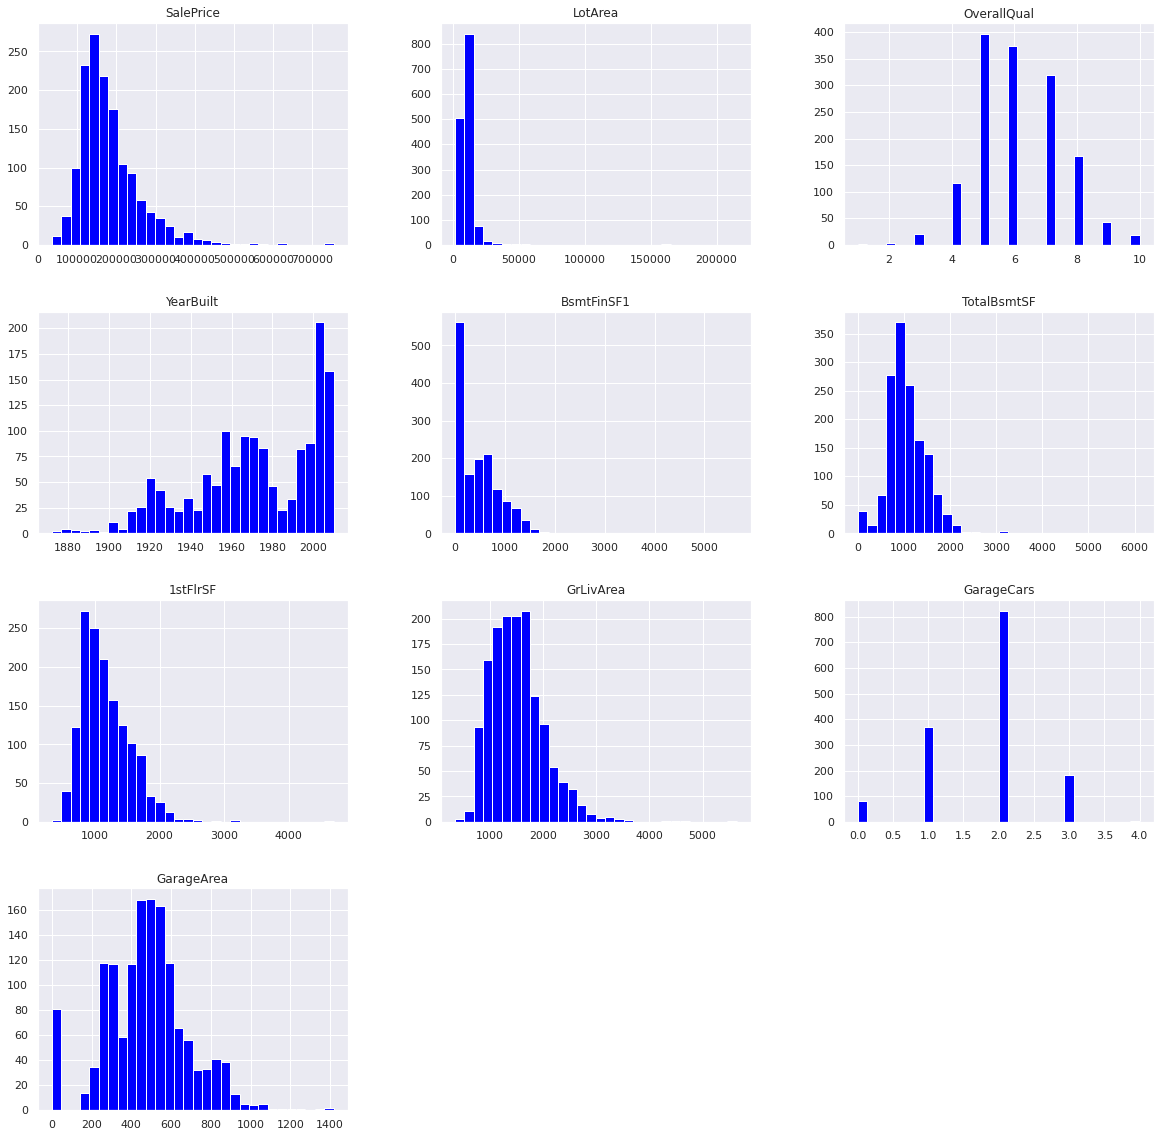

In [43]:
df.hist(bins=30,figsize=(20,20),color='blue')


#### Check skewness and kurtosis 

In [44]:
temp = np.array(df)
skew_kurt = []
for var in df:
    sk = df[var].skew()
    kt = df[var].kurt()
    skew_kurt.append("Skewedness of " + var + " is " + str(sk))
    skew_kurt.append("Kurtosis of " + var + " is " + str(kt))

In [45]:
skew_kurt

['Skewedness of SalePrice is 1.8828757597682129',
 'Kurtosis of SalePrice is 6.536281860064529',
 'Skewedness of LotArea is 12.207687851233496',
 'Kurtosis of LotArea is 203.24327101886033',
 'Skewedness of OverallQual is 0.2169439277628693',
 'Kurtosis of OverallQual is 0.09629277835615113',
 'Skewedness of YearBuilt is -0.613461172488183',
 'Kurtosis of YearBuilt is -0.43955194159361977',
 'Skewedness of BsmtFinSF1 is 1.685503071910789',
 'Kurtosis of BsmtFinSF1 is 11.118236291964712',
 'Skewedness of TotalBsmtSF is 1.5242545490627664',
 'Kurtosis of TotalBsmtSF is 13.250483281984796',
 'Skewedness of 1stFlrSF is 1.3767566220336365',
 'Kurtosis of 1stFlrSF is 5.74584148244079',
 'Skewedness of GrLivArea is 1.3665603560164552',
 'Kurtosis of GrLivArea is 4.895120580693174',
 'Skewedness of GarageCars is -0.3425489297486655',
 'Kurtosis of GarageCars is 0.22099776396532844',
 'Skewedness of GarageArea is 0.17998090674623907',
 'Kurtosis of GarageArea is 0.9170672022708684']

#### Transform variables that falls out side the range for skewness and kurtosis - [-2,2],[-7,7]
- LotArea
- BsmtFinSF1
- TotalBsmtSF

In [46]:
log_LotArea = np.log2(df['LotArea']+5)
log_BsmtFinSF1 = np.log2(df['BsmtFinSF1']+5)
sqrt_TotalBsmtSF = np.sqrt(df['TotalBsmtSF']+5)

In [47]:
print(log_LotArea.skew())
print(log_LotArea.kurt())
print(log_BsmtFinSF1.skew())
print(log_BsmtFinSF1.kurt())
print(sqrt_TotalBsmtSF.skew())
print(sqrt_TotalBsmtSF.kurt())

-0.13504988807177012
4.715684714898339
-0.5360002284480102
-1.518899176459115
-1.0522829402072469
5.536272104295319


 - All variables are now within the acceptable Skewedness and Kurtosis range, we can apply normality assumption

#### Replace the transformed variables with the old variables

In [48]:
df.drop(['LotArea','BsmtFinSF1','TotalBsmtSF'],inplace=True,axis=1)
df['log_LotArea'] = log_LotArea
df['log_BsmtFinSF1'] = log_BsmtFinSF1
df['sqrt_TotalBsmtSF'] = sqrt_TotalBsmtSF
df.shape

(1460, 10)

In [49]:
df.head(1)

,SalePrice,OverallQual,YearBuilt,1stFlrSF,GrLivArea,GarageCars,GarageArea,log_LotArea,log_BsmtFinSF1,sqrt_TotalBsmtSF
0,208500,7,2003,856,1710,2,548,13.045589,9.473706,29.342802


# Feature Scaling
- important for algorithm that performs any type of distance calculation, to ensure all features weight the same, and some features wouldn't be dominated 
- needs to be done separately on the train and test set to avoid bias in the test set
- we are splitting it the same way as before (not necessary)

#### Separate the independent and the dependent variables

In [50]:
X = df[df.columns[1:10]] 
y = df['SalePrice']

#### Split the data same way as before, same seed as well 

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### Scaling the data
- note, X_train, X_test, y_train, y_test are all scaled separately to avoid bias in the test set

In [52]:
X_train_scaled = preprocessing.scale(X_train)
X_test_scaled = preprocessing.scale(X_test)
y_train_scaled = preprocessing.scale(y_train)
y_test_scaled = preprocessing.scale(y_test)


#### Rename the column names, since scale() function changes the column names to numeric values

In [53]:
X_train_scaled = pd.DataFrame(X_train_scaled,columns=list(['OverallQual', 'YearBuilt', '1stFlrSF', 'GrLivArea', 'GarageCars',
       'GarageArea', 'log_LotArea', 'log_BsmtFinSF1', 'sqrt_TotalBsmtSF']))
X_test_scaled = pd.DataFrame(X_test_scaled,columns=list(['OverallQual', 'YearBuilt', '1stFlrSF', 'GrLivArea', 'GarageCars',
       'GarageArea', 'log_LotArea', 'log_BsmtFinSF1', 'sqrt_TotalBsmtSF']))
y_train_scaled = pd.DataFrame(y_train_scaled,columns=list(['SalePrice']))
y_test_scaled = pd.DataFrame(y_test_scaled,columns=list(['SalePrice']))


####  Concat dependent and independent varaibles together for easier analysis later on 

In [54]:
train_df = pd.concat([X_train_scaled,y_train_scaled],axis=1)
test_df = pd.concat([X_test_scaled,y_test_scaled],axis=1)

In [55]:
train_df.head(2)

,OverallQual,YearBuilt,1stFlrSF,GrLivArea,GarageCars,GarageArea,log_LotArea,log_BsmtFinSF1,sqrt_TotalBsmtSF,SalePrice
0,-0.087337,-0.260504,-0.292591,-0.901406,0.293095,0.013332,-0.059804,0.821191,-0.142023,-0.571955
1,-0.817384,1.170987,-0.122994,-0.775242,-2.436875,-2.272542,-0.146624,0.250607,0.238922,-0.447180


In [56]:
test_df.head(2)

,OverallQual,YearBuilt,1stFlrSF,GrLivArea,GarageCars,GarageArea,log_LotArea,log_BsmtFinSF1,sqrt_TotalBsmtSF,SalePrice
0,-0.041283,-0.302822,-0.220651,-0.807039,-0.943229,-0.907314,-0.137106,0.793692,0.125502,-0.305386
1,1.380045,0.764341,0.914124,2.130097,0.348351,1.120840,0.641299,0.986640,0.899847,1.684532


# Multi-Linear Regression (baseline)

#### Fit Linear regression

In [57]:
lm_mod = LinearRegression()
lm_mod.fit(X_train_scaled,y_train_scaled)

LinearRegression()

#### Make Prediction

In [58]:
y_test_pred = lm_mod.predict(X_test_scaled)

#### Check testing error

In [59]:
mlr_mse = mean_squared_error(y_test_scaled,y_test_pred)

#### Plot between true and predicted values

Text(0, 0.5, 'True')

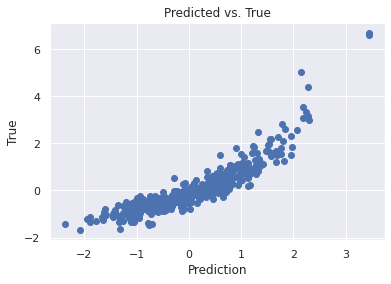

In [60]:
plt.scatter(y_test_pred, y_test_scaled)
plt.title("Predicted vs. True")
plt.xlabel("Prediction")
plt.ylabel("True")


- we can see a positive correlation between predicted and the true values, which is a good sign

#### Residual Plot

In [61]:
# sum of squared errors
err = abs(np.array(y_test_scaled)-np.array(y_test_pred))**2


Text(0, 0.5, 'squared Error')

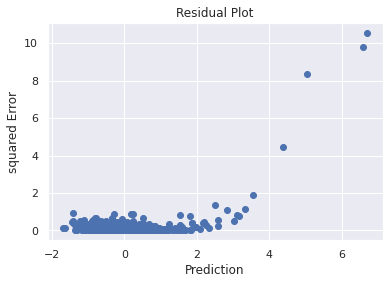

In [62]:
plt.scatter(y_test_scaled, err)
plt.title("Residual Plot")
plt.xlabel("Prediction")
plt.ylabel("squared Error")


- we can see that error is not correlated witht he prediction which is good, however we can see some outliers in our dataset

#### Check the coefficient values

In [63]:
lm_mod.coef_

array([[ 0.4175247 ,  0.13750422,  0.04419511,  0.25490021,  0.14614951,
        -0.01029696,  0.14679883,  0.10415521,  0.02651107]])

# Ridge Regression

In [64]:
ridge_alpha = [i/50000 for i in range(1, 2000, 10)]   # search optimal alpha
ridge_mse = []
for a in ridge_alpha:
    ridge_reg = Ridge(alpha=a,normalize=False, max_iter=1e5)
    ridge_reg.fit(X_train_scaled, y_train_scaled)
    ridge_mse.append(mean_squared_error(ridge_reg.predict(X_test_scaled), y_test_scaled))

Text(0, 0.5, 'MSE')

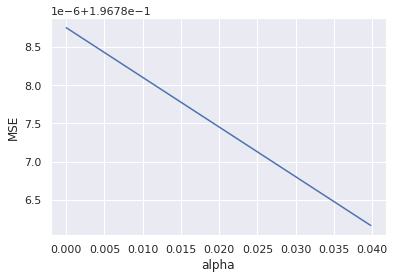

In [65]:
plt.plot(ridge_alpha,(ridge_mse))
plt.xlabel("alpha")
plt.ylabel("MSE")


#### Find optimal alpha and optimal mse

In [66]:
opt_ridge_alpha = ridge_alpha[ridge_mse.index(min(ridge_mse))]
opt_ridge_mse = min(ridge_mse)
print(f"The alpha value that yields the lowest MSE is:{opt_ridge_alpha}, which gives the mse of {opt_ridge_mse}")

The alpha value that yields the lowest MSE is:0.03982, which gives the mse of 0.19678616574492858


#### Obtain the regression coefficients

In [67]:
opt_ridge_reg = Ridge(alpha=opt_ridge_alpha,normalize=False, max_iter=1e5)
opt_ridge_reg.fit(X_train_scaled, y_train_scaled)
opt_ridge_reg.coef_

array([[ 0.41749796,  0.13750652,  0.0441996 ,  0.25489675,  0.14613024,
        -0.01026743,  0.14679051,  0.10414655,  0.02652126]])

# Lasso Regression 

#### Parameter tuning for alpha, and fit lasso regression

In [68]:
lasso_alpha = [i/50000 for i in range(1, 2000, 10)]   # search optimal alpha
lasso_mse = []
for a in lasso_alpha:
    lasso_reg = Lasso(alpha=a,normalize=False, max_iter=1e5)
    lasso_reg.fit(X_train_scaled, y_train_scaled)
    lasso_mse.append(mean_squared_error(lasso_reg.predict(X_test_scaled), y_test_scaled))

#### Plot error vs differnet alpha values

Text(0, 0.5, 'MSE')

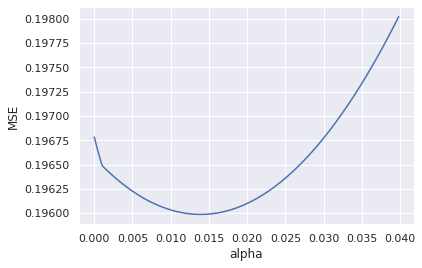

In [69]:
plt.plot(lasso_alpha,lasso_mse)
plt.xlabel("alpha")
plt.ylabel("MSE")


#### Find optimal alpha and optimal mse

In [70]:
opt_lasso_alpha = lasso_alpha[lasso_mse.index(min(lasso_mse))]
opt_lasso_mse = min(lasso_mse)
print(f"The alpha value that yields the lowest MSE is:{opt_lasso_alpha},which gives the mse of {opt_lasso_mse}")

The alpha value that yields the lowest MSE is:0.01382,which gives the mse of 0.19598643646372169


#### Obtain the coefficient regression

In [71]:
opt_lasso_reg = Lasso(alpha=opt_lasso_alpha,normalize=False, max_iter=1e5)
opt_lasso_reg.fit(X_train_scaled, y_train_scaled)
opt_lasso_reg.coef_

array([0.41602569, 0.12811157, 0.04383148, 0.24748906, 0.13567619,
       0.        , 0.13760166, 0.09252886, 0.02640976])

# Support Vector Machine
- use GridSearchCV to find the best parameters for SVR - support vector radial kernel

#### Change the shape of y to (n_samples, )

In [72]:
svr_y_train = np.ravel(y_train_scaled)
svr_y_test = np.ravel(y_test_scaled)

In [73]:
svr = svm.SVR()
parameters = {'kernel':('linear', 'rbf'), 'C':[0.5, 1, 2], 'gamma':[0.01, 0.1, 0.2], 'epsilon':[0.1, 0.2, 0.4]}

grid = GridSearchCV(svr, parameters, cv=5)
grid.fit(X_train_scaled, svr_y_train)

grid.best_params_, grid.best_score_

({'C': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}, 0.8459080263341615)

In [74]:
grid.cv_results_.get('mean_test_score')

array([0.76387201, 0.83373029, 0.76387201, 0.82207778, 0.76387201,
       0.75981289, 0.7695356 , 0.83403422, 0.7695356 , 0.81780561,
       0.7695356 , 0.76116772, 0.76222692, 0.82986622, 0.76222692,
       0.80417981, 0.76222692, 0.74627255, 0.76388756, 0.84241762,
       0.76388756, 0.83670581, 0.76388756, 0.79151573, 0.76933208,
       0.84157894, 0.76933208, 0.83334885, 0.76933208, 0.79069554,
       0.76219644, 0.83349249, 0.76219644, 0.82090953, 0.76219644,
       0.77285489, 0.76390701, 0.84590803, 0.76390701, 0.84475565,
       0.76390701, 0.81092362, 0.76936442, 0.8451215 , 0.76936442,
       0.84408493, 0.76936442, 0.8102713 , 0.76222906, 0.83651578,
       0.76222906, 0.83281255, 0.76222906, 0.79220605])

The best `C` is 2, but the score barely improves after `C = 1`. Finally, we choose `{'C': 1, 'gamma': 0.01, 'kernel': 'rbf', 'epsilon': 0.1}` as the final parameter combination.

The linear kernel performs better than rbf kernel, which indicates that linear model will also have a good performance on this problem.

Let's get start the prediction for the test data.

In [75]:
best_svr = svm.SVR(C=1, gamma=0.01, kernel='rbf', epsilon=0.1)
best_svr.fit(X_train_scaled, svr_y_train)
best_svr.score(X_test_scaled, svr_y_test)

0.8599004127261582

- The test score seems slightly better than the training score, which means the model does not overfit.  


#### Making Predictions

In [76]:
y_svr_pred = best_svr.predict(X_test_scaled)

#### Visualizing the result

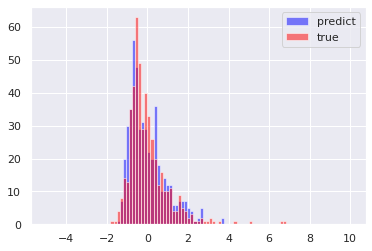

In [77]:
bins = np.linspace(-5, 10, 100)

plt.hist(y_svr_pred, bins, alpha=0.5, color="blue", label='predict')
plt.hist(svr_y_test, bins, alpha=0.5, color="red", label='true')
plt.legend(loc='upper right')
plt.show()

- From the histograms shown above, we can see the distributions of predict value and true value are similar to each other.

Text(0.5, 0, 'predict error')

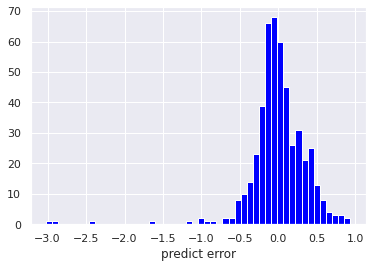

In [78]:
plt.hist(y_svr_pred-svr_y_test, bins=50, color="blue")
plt.xlabel('predict error')

- Most of predict errors are distributed within the range of [-1, 1]. Also, there is a pretintial trend that the model will produce a lower price for some data.

In [79]:
np.min(y_svr_pred-svr_y_test)

-3.021501137045977

In [80]:
np.max(y_svr_pred-svr_y_test)

0.9337703321576329

- The maximum positive deviation is around 0.93, while the maximum negative deviation is more than -3.0. Those extreme data may indicate that the house price have a non linear trend when the house price is high

In [81]:
svm_mse = mean_squared_error(svr_y_test, y_svr_pred)
svm_mse
print(f"The MSE is {svm_mse}")

The MSE is 0.1400995872738417


# K-Nearest Neighbor

#### Tuning k value (parameter) and fitting KNN
- Running KNN for k values 1:501 incrementing by 2 (all odd values, avoid potential tie in neighbors' votes)

In [82]:
neighbors = [i for i in range(1,501,2)]
knn_mse_store = []
for i in neighbors:
    knn_mod = KNeighborsRegressor(n_neighbors=i)
    knn_mod.fit(X_train_scaled, y_train_scaled)
    y_pred = knn_mod.predict(X_test_scaled)
    knn_mse_store.append(mean_squared_error(y_test_scaled,y_pred))


#### Plot the error plot

Text(0, 0.5, 'MSE')

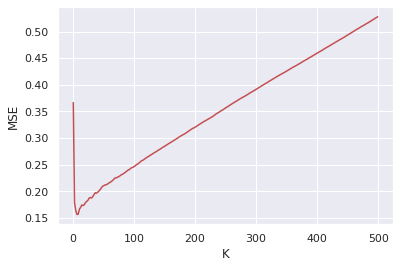

In [83]:
plt.plot(neighbors,knn_mse_store,'r')
plt.xlabel('K')
plt.ylabel('MSE')


#### Find k value with lowest testing error

In [84]:
knn_mse= min(knn_mse_store)
optim_k = knn_mse_store.index(knn_mse)
print(f"The k value that yields the lowest MSE is:{optim_k},which gives the mse of {knn_mse}")

The k value that yields the lowest MSE is:3,which gives the mse of 0.15664449321386487


# Results

#### Test accuracy

In [85]:
MSE_Vals = [mlr_mse,opt_ridge_mse,opt_lasso_mse,knn_mse,svm_mse]
test_acc = []
for mse in MSE_Vals:
    new = (1-mse)*100
    test_acc.append(new)

In [86]:
MSE_vals = pd.DataFrame([mlr_mse,opt_ridge_mse,opt_lasso_mse,knn_mse,svm_mse],columns=["MSE"])
names = ['Multi-Linear Regression (Baseline)','Ridge Regression','Lasso Regression','K-Nearest Neighbor','Support Vector Machine']
names = pd.DataFrame(names,columns=['Model'])
test_acc = pd.DataFrame(test_acc,columns=["Test Accuracy"])
pd.concat([names,test_acc],axis=1)

,Model,Test Accuracy
0,Multi-Linear Regression (Baseline),80.321125
1,Ridge Regression,80.321383
2,Lasso Regression,80.401356
3,K-Nearest Neighbor,84.335551
4,Support Vector Machine,85.990041


#### Regression Model coefficients

In [87]:
lm_mod.coef_

array([[ 0.4175247 ,  0.13750422,  0.04419511,  0.25490021,  0.14614951,
        -0.01029696,  0.14679883,  0.10415521,  0.02651107]])

In [88]:
opt_ridge_reg.coef_

array([[ 0.41749796,  0.13750652,  0.0441996 ,  0.25489675,  0.14613024,
        -0.01026743,  0.14679051,  0.10414655,  0.02652126]])

In [89]:
opt_lasso_reg.coef_

array([0.41602569, 0.12811157, 0.04383148, 0.24748906, 0.13567619,
       0.        , 0.13760166, 0.09252886, 0.02640976])

#### FInal feature space

In [90]:
feat_importances.nlargest(9)

OverallQual    0.549297
GrLivArea      0.130685
TotalBsmtSF    0.036217
BsmtFinSF1     0.035321
1stFlrSF       0.030024
GarageCars     0.020912
LotArea        0.019401
GarageArea     0.019300
YearBuilt      0.017807
dtype: float64

#### Discussion

- SVM is shown to have the highest test accuracy followed closely by KNN.
- Regression models seem to have similar test accuracies to each together, this is because ridge and lasso are techniques to reduce the model complexity and prevent overfitting. Since our feature selection step (random forest) was quite liberal with reducing features - about 81 features were removed. Therefore the penalizing effects of Lasso and Ridge did not have its full effect at this set of features. As shown above that the coefficient values between our baseline model, iIdge and Lasso are very similar. Therefore, it makes a lot of sense that the test accuracies for three models are similar to each other.
- Lastly, we have concretized our feature space from 80 to 9 variables, this severely prevented the posibility of overfitting 